In [2]:
!pip install rarfile
import numpy as np
import urllib.request
import rarfile
import matplotlib.pyplot as plt
import random
from time import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Part 1
# Load the datasets
def pullData(url):
  urllib.request.urlretrieve(url, "Qualitative_Bankruptcy%20(250%20instances).rar")
  with rarfile.RarFile("Qualitative_Bankruptcy%20(250%20instances).rar", "r") as rf:
      rf.extractall()
      
  rawData = np.loadtxt("Qualitative_Bankruptcy/Qualitative_Bankruptcy.data.txt", dtype=str, delimiter=',')

  # Positive means good, no risk
  input_mapping = {'P': -1, 'A': 0, 'N': 1}
  output_mapping = {'B': 1, 'NB': 0}

  industrial_risk = np.array([input_mapping[item] for item in rawData[:, 0]])
  management_risk = np.array([input_mapping[item] for item in rawData[:, 1]])
  financial_flexibility = np.array([input_mapping[item] for item in rawData[:, 2]])
  credibility = np.array([input_mapping[item] for item in rawData[:, 3]])
  competitiveness = np.array([input_mapping[item] for item in rawData[:, 4]])
  operation_risk = np.array([input_mapping[item] for item in rawData[:, 5]])

  outcome = np.array([output_mapping[item] for item in rawData[:, 6]])

  X = np.array([industrial_risk, management_risk, financial_flexibility, credibility,
                competitiveness, operation_risk])

  return outcome, X.T


In [ ]:
# Part 2
class LogisticRegression:

    # Hyperparameters are set in fit() instead of here, because it makes
    # testing easier by not needing new instances of LogisticRegression
    def __init__(self):
      pass

    def activation(self, x):
      return 1 / (1 + np.exp(-x))
    
    def gradient(self, w, x, y):
      N = x.shape[0]
      D = x.shape[1]
      return np.dot(x.T, self.activation(np.dot(x, w)) - y) / N
    
    def fit(self, x, y, lr=.01, eps=1e-2, mini_batch=False, fit_bias=True,
            batch_size=16, do_max_iter=False, max_iter=1e5):
      
      self.fit_bias = fit_bias
      if x.ndim == 1:
          x = x[:, None]
      if fit_bias:
          N = x.shape[0]
          x = np.column_stack([x,np.ones(N)])
      N,D = x.shape
      self.w = np.zeros(D)
      g = np.inf 

      iters = 0
      while np.linalg.norm(g) > eps:
          if mini_batch:
              idxs = np.random.choice(N, size=batch_size, replace=False)
              xb = x[idxs, :]
              yb = y[idxs]
              g = self.gradient(self.w, xb, yb)
          else:
              g = self.gradient(self.w, x, y)

          self.w -= lr * g

          if do_max_iter and iters >= max_iter:
            break
            
          iters += 1
    
    def predict(self, x):
      if x.ndim == 1:
          x = x[:, None]
      Nt = x.shape[0]
      if self.fit_bias:
          x = np.column_stack([x,np.ones(Nt)])
      yh = self.activation(np.dot(x, self.w))  # predict output
      return yh


In [ ]:
class LogisticRegressionTester:
  def __init__(self, rand_seed=31):
    self.rand_seed = rand_seed
    pass

  def splitData(self, x, y, test_proportion=0.5):
    np.random.seed(self.rand_seed)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    split_point = int(test_proportion * x.shape[0])
    x_test = x[:split_point, :]
    x_train = x[split_point:, :]

    y_test = y[:split_point]
    y_train = y[split_point:]
    return x_test, y_test, x_train, y_train
  
  def getAccuracyPercentage(self, estimation, reality, decision_boundary=0.5):
    bEstimation = np.where(estimation > decision_boundary, 1, 0)
    error_vector = np.bitwise_xor(reality, bEstimation)
    return 100 * (1 - (np.sum(error_vector) / len(error_vector)))


In [ ]:
outcome, X = pullData("https://archive.ics.uci.edu/ml/machine-learning-databases/00281/Qualitative_Bankruptcy%20(250%20instances).rar")

tester = LogisticRegressionTester()
regression = LogisticRegression()


Training the model and displaying feature weights as well as performance


In [ ]:
xte, yte, xtr, ytr = tester.splitData(X, outcome,test_proportion=0.2)

fit_time_buf = list()
pred_time_buf = list()

# Run 10 times to get an average time
for i in range(0, 10):
  start_time = time()
  regression.fit(xtr, ytr, lr=0.002, eps=1e-2, mini_batch=False)
  end_time = time()
  t = end_time - start_time
  fit_time_buf.append(t)

  start_time = time()
  prediction = regression.predict(xte)
  end_time = time()
  t = end_time - start_time
  pred_time_buf.append(t)

time_elapsed_training = round(1000 * np.mean(fit_time_buf), 2)
time_elapsed_classifying = round(1000 * np.mean(pred_time_buf), 2)

accuracy = tester.getAccuracyPercentage(prediction, yte)
print("Results")
print("____________________________________________________________________")
print("Weights:")
print(regression.w[:6])
print("\nBias term: ")
print(regression.w[6])
print("\n\nPerformance:")
print("____________________________________________________________________")
print("Classification accuracy: " + str(accuracy) + "%")
print("Training done in " + str(time_elapsed_training) + "ms")
print("Classification done in " + str(time_elapsed_classifying) + "ms")


Results
____________________________________________________________________
Weights:
[0.49238342 0.28612975 1.92275838 1.96136404 3.69902732 0.1433452 ]

Bias term: 
-2.1724791968811257


Performance:
____________________________________________________________________
Classification accuracy: 100.0%
Training done in 2484.67ms
Classification done in 0.08ms


Testing the effects of training data size

In [ ]:
train_percentages = list()
times = list()
train_performances = list()
test_performances = list()

for i in range(0, 10):
  percentage = 1 - i/10
  xte, yte, xtr, ytr = tester.splitData(X, outcome,test_proportion=percentage)
  train_percentages.append(i/10)

  t_buf = list()
  train_buf = list()
  test_buf = list()

  for j in range(0, 10):
    start_time = time()
    regression.fit(xtr, ytr, lr=0.002, eps=1e-2, mini_batch=False, batch_size=16)
    end_time = time()
    time_elapsed = end_time - start_time
    t_buf.append(time_elapsed)
    predicted1 = regression.predict(xtr)
    train_buf.append(tester.getAccuracyPercentage(predicted1, ytr))
    predicted2 = regression.predict(xte)
    test_buf.append(tester.getAccuracyPercentage(predicted2, yte))
  
  train_performances.append(np.mean(train_buf))
  test_performances.append(np.mean(test_buf))
  times.append(np.mean(t_buf))

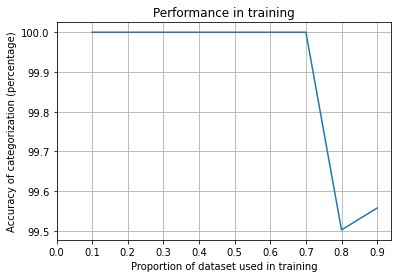

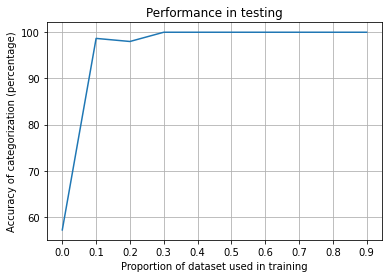

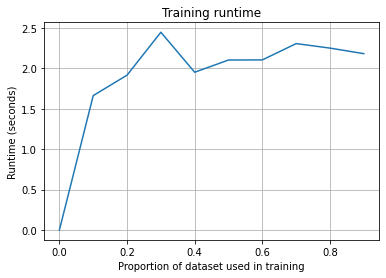

In [ ]:
plt.plot(train_percentages, train_performances)
plt.title("Performance in training")
plt.xlabel("Proportion of dataset used in training")
plt.xticks(np.arange(0.0, 1.0, 0.1))
plt.ylabel("Accuracy of categorization (percentage)")
plt.grid()
plt.figure()
plt.plot(train_percentages, test_performances)
plt.title("Performance in testing")
plt.xlabel("Proportion of dataset used in training")
plt.xticks(np.arange(0.0, 1.0, 0.1))
plt.ylabel("Accuracy of categorization (percentage)")
plt.grid()

plt.figure()
plt.plot(train_percentages, times)
plt.title("Training runtime")
plt.xlabel("Proportion of dataset used in training")
plt.ylabel("Runtime (seconds)")
plt.grid()

Testing the effects of batch sizes on runtime and accuracy

In [ ]:
batch_sizes = list()
times = list()
test_performances = list()
xte, yte, xtr, ytr = tester.splitData(X, outcome,test_proportion=0.5)

# Run the regression in growing batch sizes
for i in range(0, 6):
  batches = (2 ** i)
  batch_sizes.append(batches)

  t_buf = list()
  test_buf = list()

  for j in range(0, 10):
    start_time = time()
    regression.fit(xtr, ytr, lr=0.002, eps=1e-2, mini_batch=True, batch_size=batches)
    end_time = time()
    time_elapsed = end_time - start_time
    t_buf.append(time_elapsed)
    predicted = regression.predict(xte)
    test_buf.append(tester.getAccuracyPercentage(predicted, yte))
  
  test_performances.append(np.mean(test_buf))
  times.append(np.mean(t_buf))

  t_buf = list()
  test_buf = list()
  # Run the regression with default settings for reference
  for j in range(0, 10):
    start_time = time()
    regression.fit(xtr, ytr, lr=0.002, eps=1e-2, mini_batch=False)
    end_time = time()
    time_elapsed = end_time - start_time
    t_buf.append(time_elapsed)
    predicted = regression.predict(xte)
    test_buf.append(tester.getAccuracyPercentage(predicted, yte))
  
  baseline_accuracy = np.mean(test_buf)
  baseline_runtime = np.mean(t_buf)

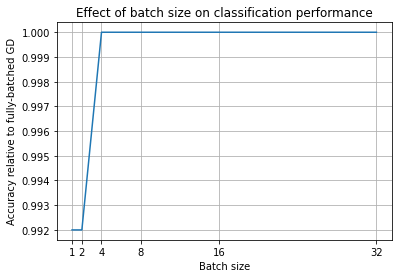

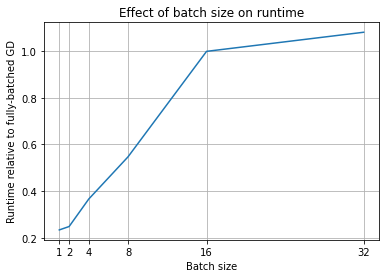

In [ ]:
plt.plot(batch_sizes, test_performances/baseline_accuracy)
plt.title("Effect of batch size on classification performance")
plt.xlabel("Batch size")
plt.xticks([1, 2, 4, 8, 16, 32])
plt.ylabel("Accuracy relative to fully-batched GD")
plt.grid()
plt.figure()
plt.plot(batch_sizes, times/baseline_runtime)
plt.title("Effect of batch size on runtime")
plt.xlabel("Batch size")
plt.xticks([1, 2, 4, 8, 16, 32])
plt.ylabel("Runtime relative to fully-batched GD")
plt.grid()

In [ ]:
rates = list()
times = list()
test_performances = list()
xte, yte, xtr, ytr = tester.splitData(X, outcome,test_proportion=0.2)

# Run the regression in growing batch sizes
for i in range(0, 10):
  learning_rate = 0.0002 * (10 ** i)
  rates.append(learning_rate)

  t_buf = list()
  test_buf = list()

  for j in range(0, 3):
    start_time = time()
    regression.fit(xtr, ytr, lr=learning_rate, eps=1e-2, mini_batch=False, do_max_iter=True, max_iter=1e6)
    end_time = time()
    time_elapsed = end_time - start_time
    t_buf.append(time_elapsed)
    predicted = regression.predict(xte)
    test_buf.append(tester.getAccuracyPercentage(predicted, yte))
  
  test_performances.append(np.mean(test_buf))
  times.append(np.mean(t_buf))


<ipython-input-315-a6e1bd4cdb27>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [ ]:
print(times)
print(test_performances)
print(rates)

[23.620821475982666, 2.4665635426839194, 0.1932851473490397, 0.02416880925496419, 0.0019573370615641275, 0.0002608299255371094, 0.00023476282755533853, 0.0006517569224039713, 0.0002829233805338542, 0.00028006235758463543]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.0002, 0.002, 0.02, 0.2, 2.0, 20.0, 200.0, 2000.0, 20000.0, 200000.0]


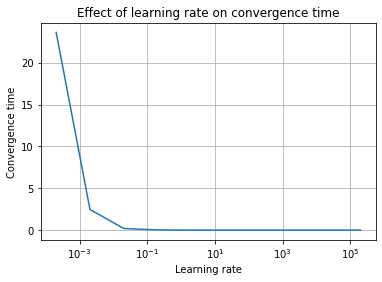

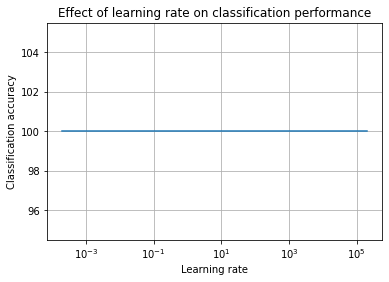

In [10]:
time = [23.620821475982666, 2.4665635426839194, 0.1932851473490397, 0.02416880925496419, 0.0019573370615641275, 0.0002608299255371094, 0.00023476282755533853, 0.0006517569224039713, 0.0002829233805338542, 0.00028006235758463543]
accuracy = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
rates = [0.0002, 0.002, 0.02, 0.2, 2.0, 20.0, 200.0, 2000.0, 20000.0, 200000.0]

plt.figure()
plt.semilogx(rates, time)
plt.title("Effect of learning rate on convergence time")
plt.xlabel("Learning rate")
plt.ylabel("Convergence time")
plt.grid()

plt.figure()
plt.semilogx(rates, accuracy)
plt.title("Effect of learning rate on classification performance")
plt.xlabel("Learning rate")
plt.ylabel("Classification accuracy")
plt.grid()